In [1]:
import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import ParabolaGen
import NoiseGen

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [3]:
x_dim = 92
y_dim = 120
time_dimension = 1000
num_of_files = 1
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)

train_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 128, origin).unsqueeze(1)
test_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 32, origin).unsqueeze(1)

train_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(128, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(128, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + train_data, 0, 1)
test_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(32, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(32, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + test_data, 0, 1)

In [4]:
train_data.shape

torch.Size([128, 1, 120, 92])

Text(0.5, 1.0, 'Noisy Image')

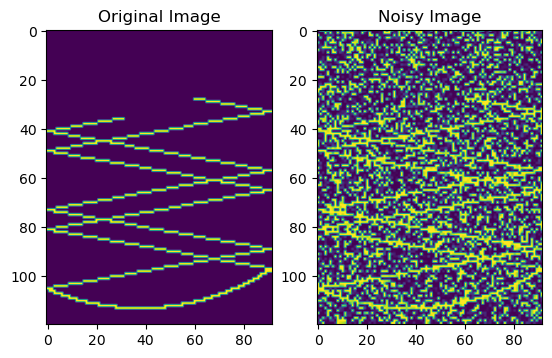

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data_noisy[0][0])

ax[0].set_title("Original Image")
ax[1].set_title("Noisy Image")

In [6]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),  # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1), # Output: (64, 15, 12)
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            # torch.nn.Flatten(1),
            # torch.nn.Linear(64*114*84, 128),
            # torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(128, 64*114*84),
            # torch.nn.ReLU(),
            # torch.nn.Unflatten(1, (64, 114, 84)),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1), # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1), # Output: (1, 120, 90)
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
summary(ConvolutionAutoencoder(), input_size=(1, 1, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 1, 120, 92]           --
├─Sequential: 1-1                        [1, 8, 114, 86]           --
│    └─Conv2d: 2-1                       [1, 64, 118, 90]          640
│    └─BatchNorm2d: 2-2                  [1, 64, 118, 90]          128
│    └─ReLU: 2-3                         [1, 64, 118, 90]          --
│    └─Conv2d: 2-4                       [1, 16, 116, 88]          9,232
│    └─BatchNorm2d: 2-5                  [1, 16, 116, 88]          32
│    └─ReLU: 2-6                         [1, 16, 116, 88]          --
│    └─Conv2d: 2-7                       [1, 8, 114, 86]           1,160
│    └─BatchNorm2d: 2-8                  [1, 8, 114, 86]           16
│    └─ReLU: 2-9                         [1, 8, 114, 86]           --
├─Sequential: 1-2                        [1, 1, 120, 92]           --
│    └─ConvTranspose2d: 2-10             [1, 16, 116, 88]          1,168
│   

In [8]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [9]:
for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.to(device))
    loss = loss_function(outputs, train_data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


In [25]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder(test_data_noisy.to(device))
    loss = loss_function(pred, test_data.to(device))
    print("Test Loss: ", loss.item())
    

Test Loss:  0.008720342069864273


Text(0.5, 0.98, 'Linear Autoencoder')

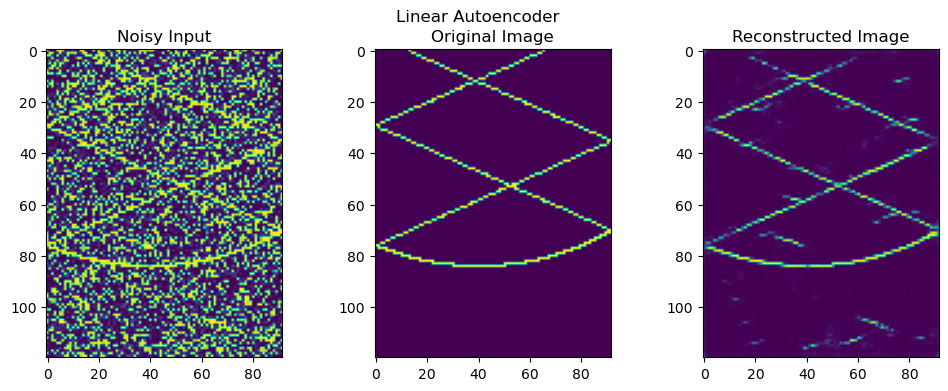

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0])
ax[1].imshow(test_data[0][0])
ax[2].imshow(pred[0, 0].cpu().numpy())

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

plt.suptitle("Linear Autoencoder")

In [26]:
# refine pred to be binary
pred_max = pred.max()
pred_min = pred.min()
pred = (pred - pred_min) / (pred_max - pred_min)
pred_binary = torch.where(pred > 0.5, 1, 0)

Text(0.5, 0.98, 'Linear Autoencoder')

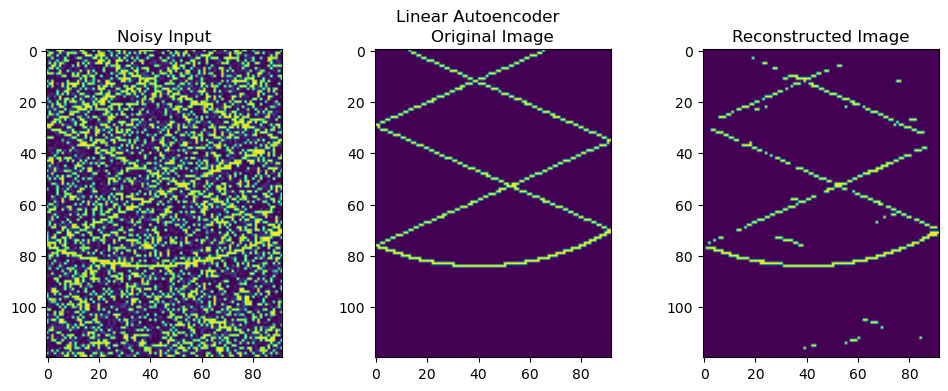

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0])
ax[1].imshow(test_data[0][0])
ax[2].imshow(pred_binary[0, 0].cpu().numpy())

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

plt.suptitle("Linear Autoencoder")

In [28]:
# measure the percentage of false-positive, false-negative, true-positive, true-negative
# measure the accuracy

original_img = test_data[0][0]
reconstructed_img = pred_binary[0, 0].cpu()

original_img = original_img.unsqueeze(-1)
reconstructed_img = reconstructed_img.unsqueeze(-1)

false_positive = torch.sum((reconstructed_img == 1) & (original_img == 0)).item()
false_negative = torch.sum((reconstructed_img == 0) & (original_img == 1)).item()
true_positive = torch.sum((reconstructed_img == 1) & (original_img == 1)).item()
true_negative = torch.sum((reconstructed_img == 0) & (original_img == 0)).item()

print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")
print(f"True Positive: {true_positive}")
print(f"True Negative: {true_negative}")

false_positive_rate = false_positive / (false_positive + true_negative)
print(f"False Positive Rate: {false_positive_rate}")
false_negative_rate = false_negative / (false_negative + true_positive)
print(f"False Negative Rate: {false_negative_rate}")
senstivity = true_positive / (true_positive + false_negative)
print(f"Sensitivity: {senstivity}")
specificity = true_negative / (true_negative + false_positive)
print(f"Specificity: {specificity}")
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy}")

False Positive: 70
False Negative: 106
True Positive: 339
True Negative: 10525
False Positive Rate: 0.0066068900424728644
False Negative Rate: 0.23820224719101124
Sensitivity: 0.7617977528089888
Specificity: 0.9933931099575272
Accuracy: 0.9840579710144928
